In [27]:
import random
import os

def generate_data(nodes_number, x_range, y_range, seed):
    if seed is not None:
        random.seed(seed)

    data = []
    used_coordinates = set()

    while len(data) < nodes_number:
        x = random.randint(x_range[0], x_range[1])
        y = random.randint(y_range[0], y_range[1])

        if (x, y) not in used_coordinates:
            used_coordinates.add((x, y))
            data.append((len(data) + 1, x, y))
    return data

def write_to_file(filename, data):
    with open(filename, "w") as f:
        for entry in data:
            f.write(f"{entry[0]} {entry[1]} {entry[2]}\n")


NODES_NUMBER = 5000
X_RANGE = (0, 5000)
Y_RANGE = (0, 5000)
SEED = 1
data = generate_data(NODES_NUMBER, X_RANGE, Y_RANGE, SEED)


filename = "TSP.txt"
if os.path.exists(filename):
    os.remove(filename)

write_to_file(filename, data)

print(f"Randomly generated '{NODES_NUMBER}' Cities and written to '{filename}'")

Randomly generated '100' Cities and written to 'TSP_test.txt'


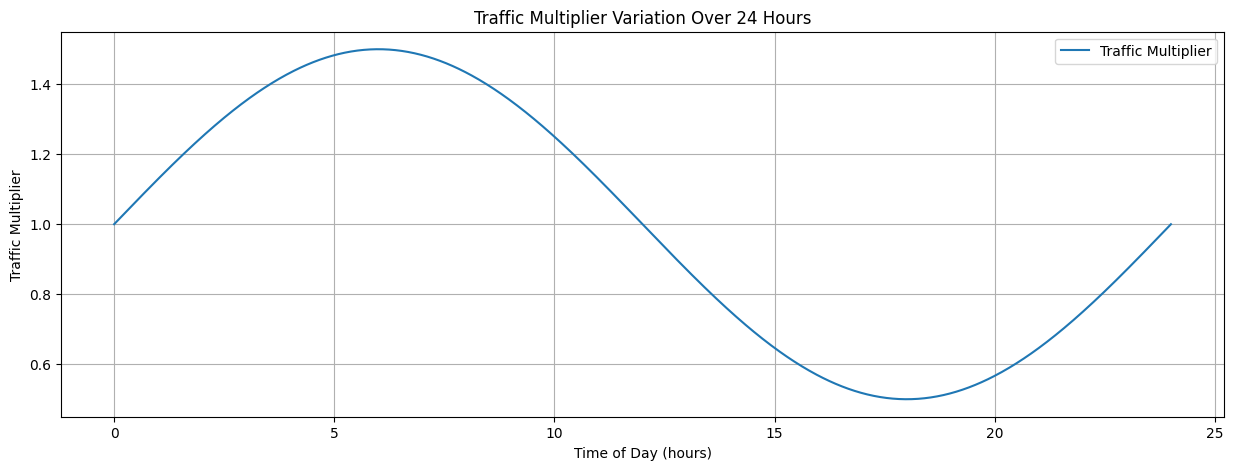

In [9]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.linspace(0, 24, 1000)
TRAFFIC_FUNCTION = 1 + 0.5 * np.sin(hours / 24 * 2 * np.pi)

plt.figure(figsize=(15, 5))
plt.plot(hours, TRAFFIC_FUNCTION, label="Traffic Multiplier")
plt.xlabel("Time of Day (hours)")
plt.ylabel("Traffic Multiplier")
plt.title("Traffic Multiplier Variation Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()

In [32]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import cycle
from collections import deque
import pandas as pd
import os
import time
from tqdm import tqdm  # Import tqdm for progress bar

os.environ["OMP_NUM_THREADS"] = "4"

def get_city(is_test=False):
    filename = "TSP_test.txt" if is_test else "TSP.txt"
    cities = []
    with open(filename) as f:
        for i in f.readlines():
            node_city_val = i.split()
            cities.append(
                [node_city_val[0], float(node_city_val[1]), float(node_city_val[2])]
            )
    return cities

def calculate_travel_time(cityA, cityB, time):
    base_distance = math.sqrt(
        math.pow(cityB[1] - cityA[1], 2) + math.pow(cityB[2] - cityA[2], 2)
    )
    traffic_multiplier = 1 + 0.5 * np.sin(time / 24 * 2 * np.pi)
    travel_time = base_distance * traffic_multiplier
    return travel_time

def calculate_distance_matrix(cities):
    n = len(cities)
    distance_matrix = np.zeros((n, n))
    for i in tqdm(range(n), desc="Calculating distance matrix"):  # Add progress bar
        for j in range(i + 1, n):
            distance = calculate_travel_time(cities[i], cities[j], 0)
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    return distance_matrix

def calculate_total_time(solution, distance_matrix):
    total_time = 0
    for i in range(len(solution) - 1):
        cityA = solution[i]
        cityB = solution[i + 1]
        total_time += distance_matrix[cityA][cityB]
    cityA = solution[0]
    cityB = solution[-1]
    total_time += distance_matrix[cityB][cityA]
    return total_time

def cluster_cities(cities, k):
    coordinates = np.array([[city[1], city[2]] for city in cities])
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    
    with tqdm(total=len(coordinates), desc="Clustering cities") as pbar:
        kmeans.fit(coordinates)
        pbar.update(len(coordinates))
    
    clusters = [[] for _ in range(k)]
    for idx, label in enumerate(kmeans.labels_):
        clusters[label].append(idx)
    return clusters, kmeans.labels_

def nearest_neighbor_path(cluster, distance_matrix):
    unvisited = set(cluster)
    path = [unvisited.pop()]
    while unvisited:
        nearest_city = min(unvisited, key=lambda city: distance_matrix[path[-1]][city])
        path.append(nearest_city)
        unvisited.remove(nearest_city)
    return path

def connect_clusters(clusters, distance_matrix):
    paths = []
    for cluster in clusters:
        path = nearest_neighbor_path(cluster, distance_matrix)
        paths.append(path)
    connected_path = [city for path in paths for city in path]
    return connected_path

def generate_initial_solution(cities, distance_matrix):
    clusters, labels = cluster_cities(cities, K_CLUSTERS)
    solution = connect_clusters(clusters, distance_matrix)
    return solution, labels

def generate_neighbors(solution, distance_matrix, sample_size):
    neighbors = []
    for _ in range(sample_size):
        neighbor = solution[:]
        move_type = random.choice(["swap", "reverse", "insert"])
        if move_type == "swap":
            i, j = random.sample(range(1, len(neighbor)), 2)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        elif move_type == "reverse":
            i, j = sorted(random.sample(range(1, len(neighbor)), 2))
            neighbor[i:j] = reversed(neighbor[i:j])
        elif move_type == "insert":
            i, j = random.sample(range(1, len(neighbor)), 2)
            if i < j:
                neighbor.insert(j, neighbor.pop(i))
            else:
                neighbor.insert(i, neighbor.pop(j))
        neighbors.append((neighbor, calculate_total_time(neighbor, distance_matrix)))
    return neighbors

def tabu_search(
    initial_solution, distance_matrix, tabu_tenure, iterations, sample_size, isTest
):
    best_solution = initial_solution
    best_cost = calculate_total_time(initial_solution, distance_matrix)
    current_solution = initial_solution
    current_cost = best_cost
    tabu_list = deque(maxlen=tabu_tenure)

    iteration_costs = []  # List to store costs at each 10th iteration

    print(f"Initial Solution Cost: {best_cost}")

    for iteration in tqdm(range(iterations), desc="Tabu search iterations"):  # Add progress bar here
        neighborhood = generate_neighbors(
            current_solution, distance_matrix, sample_size
        )
        neighborhood = sorted(neighborhood, key=lambda x: x[1])

        for candidate in neighborhood:
            if tuple(candidate[0]) not in tabu_list:
                current_solution = candidate[0]
                current_cost = candidate[1]
                tabu_list.append(tuple(candidate[0]))
                break

        if current_cost < best_cost:
            best_solution = current_solution
            best_cost = current_cost
        else:
            current_solution = best_solution
            current_cost = best_cost

        if iteration % 10 == 0:
            iteration_costs.append(current_cost)  # Store the cost every 10 iterations

    return best_solution, best_cost, iteration_costs  # Return the iteration costs

def drawMap(cities, path, labels, k):
    plt.figure(figsize=(50, 50))
    colors = cycle(plt.cm.tab20.colors)

    for j in range(len(cities)):
        plt.plot(cities[j][1], cities[j][2], "ro")
        # plt.annotate(cities[j][0], (cities[j][1], cities[j][2]))

    color_map = {i: next(colors) for i in range(k)}
    for i in range(len(path) - 1):
        first = path[i]
        second = path[i + 1]
        cluster_color = color_map[labels[first]]
        plt.plot(
            [cities[first][1], cities[second][1]],
            [cities[first][2], cities[second][2]],
            color=cluster_color,
        )
    first = path[0]
    second = path[-1]
    plt.plot(
        [cities[first][1], cities[second][1]],
        [cities[first][2], cities[second][2]],
        "blue",
    )
    plt.show()

def main():
    cities = get_city()
    print("----------------------------------------------------------------")
    print("Step 1/3")
    distance_matrix = calculate_distance_matrix(cities)
    print("----------------------------------------------------------------")
    print("Step 2/3")
    initial_solution, labels = generate_initial_solution(cities, distance_matrix)
    print("----------------------------------------------------------------")
    print("Step 3/3")
    best_solution, best_cost, iteration_costs = tabu_search(
        initial_solution,
        distance_matrix,
        TABU_TENURE,
        ITERATIONS,
        int(len(cities) / K_CLUSTERS),
        False
    )

    print("\n----------------------------------------------------------------")
    print(
        f"Initial solution cost: {calculate_total_time(initial_solution, distance_matrix)}"
    )
    print(f"Best solution cost: {best_cost}")
    print("----------------------------------------------------------------\n")

    drawMap(cities, best_solution, labels, K_CLUSTERS)

    # Plotting the iteration costs
    plt.figure(figsize=(12, 8))
    plt.plot(range(0, ITERATIONS, 10), iteration_costs, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs Iterations')
    plt.grid(True)
    plt.show()

def analyze_performance(k_clusters_list, tabu_tenure_list, iterations_list):
    cities = get_city(True)
    distance_matrix = calculate_distance_matrix(cities)

    results = []
    total_iterations = len(k_clusters_list) * len(tabu_tenure_list) * len(iterations_list)
    iteration_count = 0

    for k_clusters in k_clusters_list:
        global K_CLUSTERS
        K_CLUSTERS = k_clusters
        for tabu_tenure in tabu_tenure_list:
            for iterations in iterations_list:
                iteration_count += 1
                print("---------------------------------------------------------------------")
                print(f"Starting iteration {iteration_count} of {total_iterations}")
                print(f"Parameters: K_CLUSTERS={k_clusters}, TABU_TENURE={tabu_tenure}, ITERATIONS={iterations}")
                print("---------------------------------------------------------------------")
                start_time = time.time()
                initial_solution, labels = generate_initial_solution(
                    cities, distance_matrix
                )
                best_solution, best_cost, _ = tabu_search(
                    initial_solution,
                    distance_matrix,
                    tabu_tenure,
                    iterations,
                    int(len(cities) / K_CLUSTERS),
                    True
                )
                end_time = time.time()
                computation_time = end_time - start_time

                initial_solution_cost = calculate_total_time(
                    initial_solution, distance_matrix
                )

                results.append(
                    {
                        "K_CLUSTERS": k_clusters,
                        "TABU_TENURE": tabu_tenure,
                        "ITERATIONS": iterations,
                        "Initial Solution Cost": initial_solution_cost,
                        "Best Solution Cost": best_cost,
                        "Computation Time": computation_time,
                    }
                )

    df = pd.DataFrame(results)

    # Visualization
    plt.figure(figsize=(12, 8))
    for k_clusters in df["K_CLUSTERS"].unique():
        subset = df[df["K_CLUSTERS"] == k_clusters]
        plt.plot(
            subset["ITERATIONS"],
            subset["Best Solution Cost"],
            label=f"K_CLUSTERS={k_clusters}",
        )
    plt.xlabel("Iterations")
    plt.ylabel("Best Solution Cost")
    plt.title("Best Solution Cost vs Iterations for Different K_CLUSTERS")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    for k_clusters in df["K_CLUSTERS"].unique():
        subset = df[df["K_CLUSTERS"] == k_clusters]
        plt.plot(
            subset["ITERATIONS"],
            subset["Computation Time"],
            label=f"K_CLUSTERS={k_clusters}",
        )
    plt.xlabel("Iterations")
    plt.ylabel("Computation Time (seconds)")
    plt.title("Computation Time vs Iterations for Different K_CLUSTERS")
    plt.legend()
    plt.show()

# Main execution

----------------------------------------------------------------
Step 1/3


Calculating distance matrix: 100%|██████████| 5000/5000 [00:19<00:00, 259.26it/s] 


----------------------------------------------------------------
Step 2/3


Clustering cities: 100%|██████████| 5000/5000 [00:00<00:00, 8673.33it/s]


----------------------------------------------------------------
Step 3/3
Initial Solution Cost: 160753.22301905154


Tabu search iterations: 100%|██████████| 3000/3000 [14:39<00:00,  3.41it/s]



----------------------------------------------------------------
Initial solution cost: 160753.22301905154
Best solution cost: 153864.7901548302
----------------------------------------------------------------



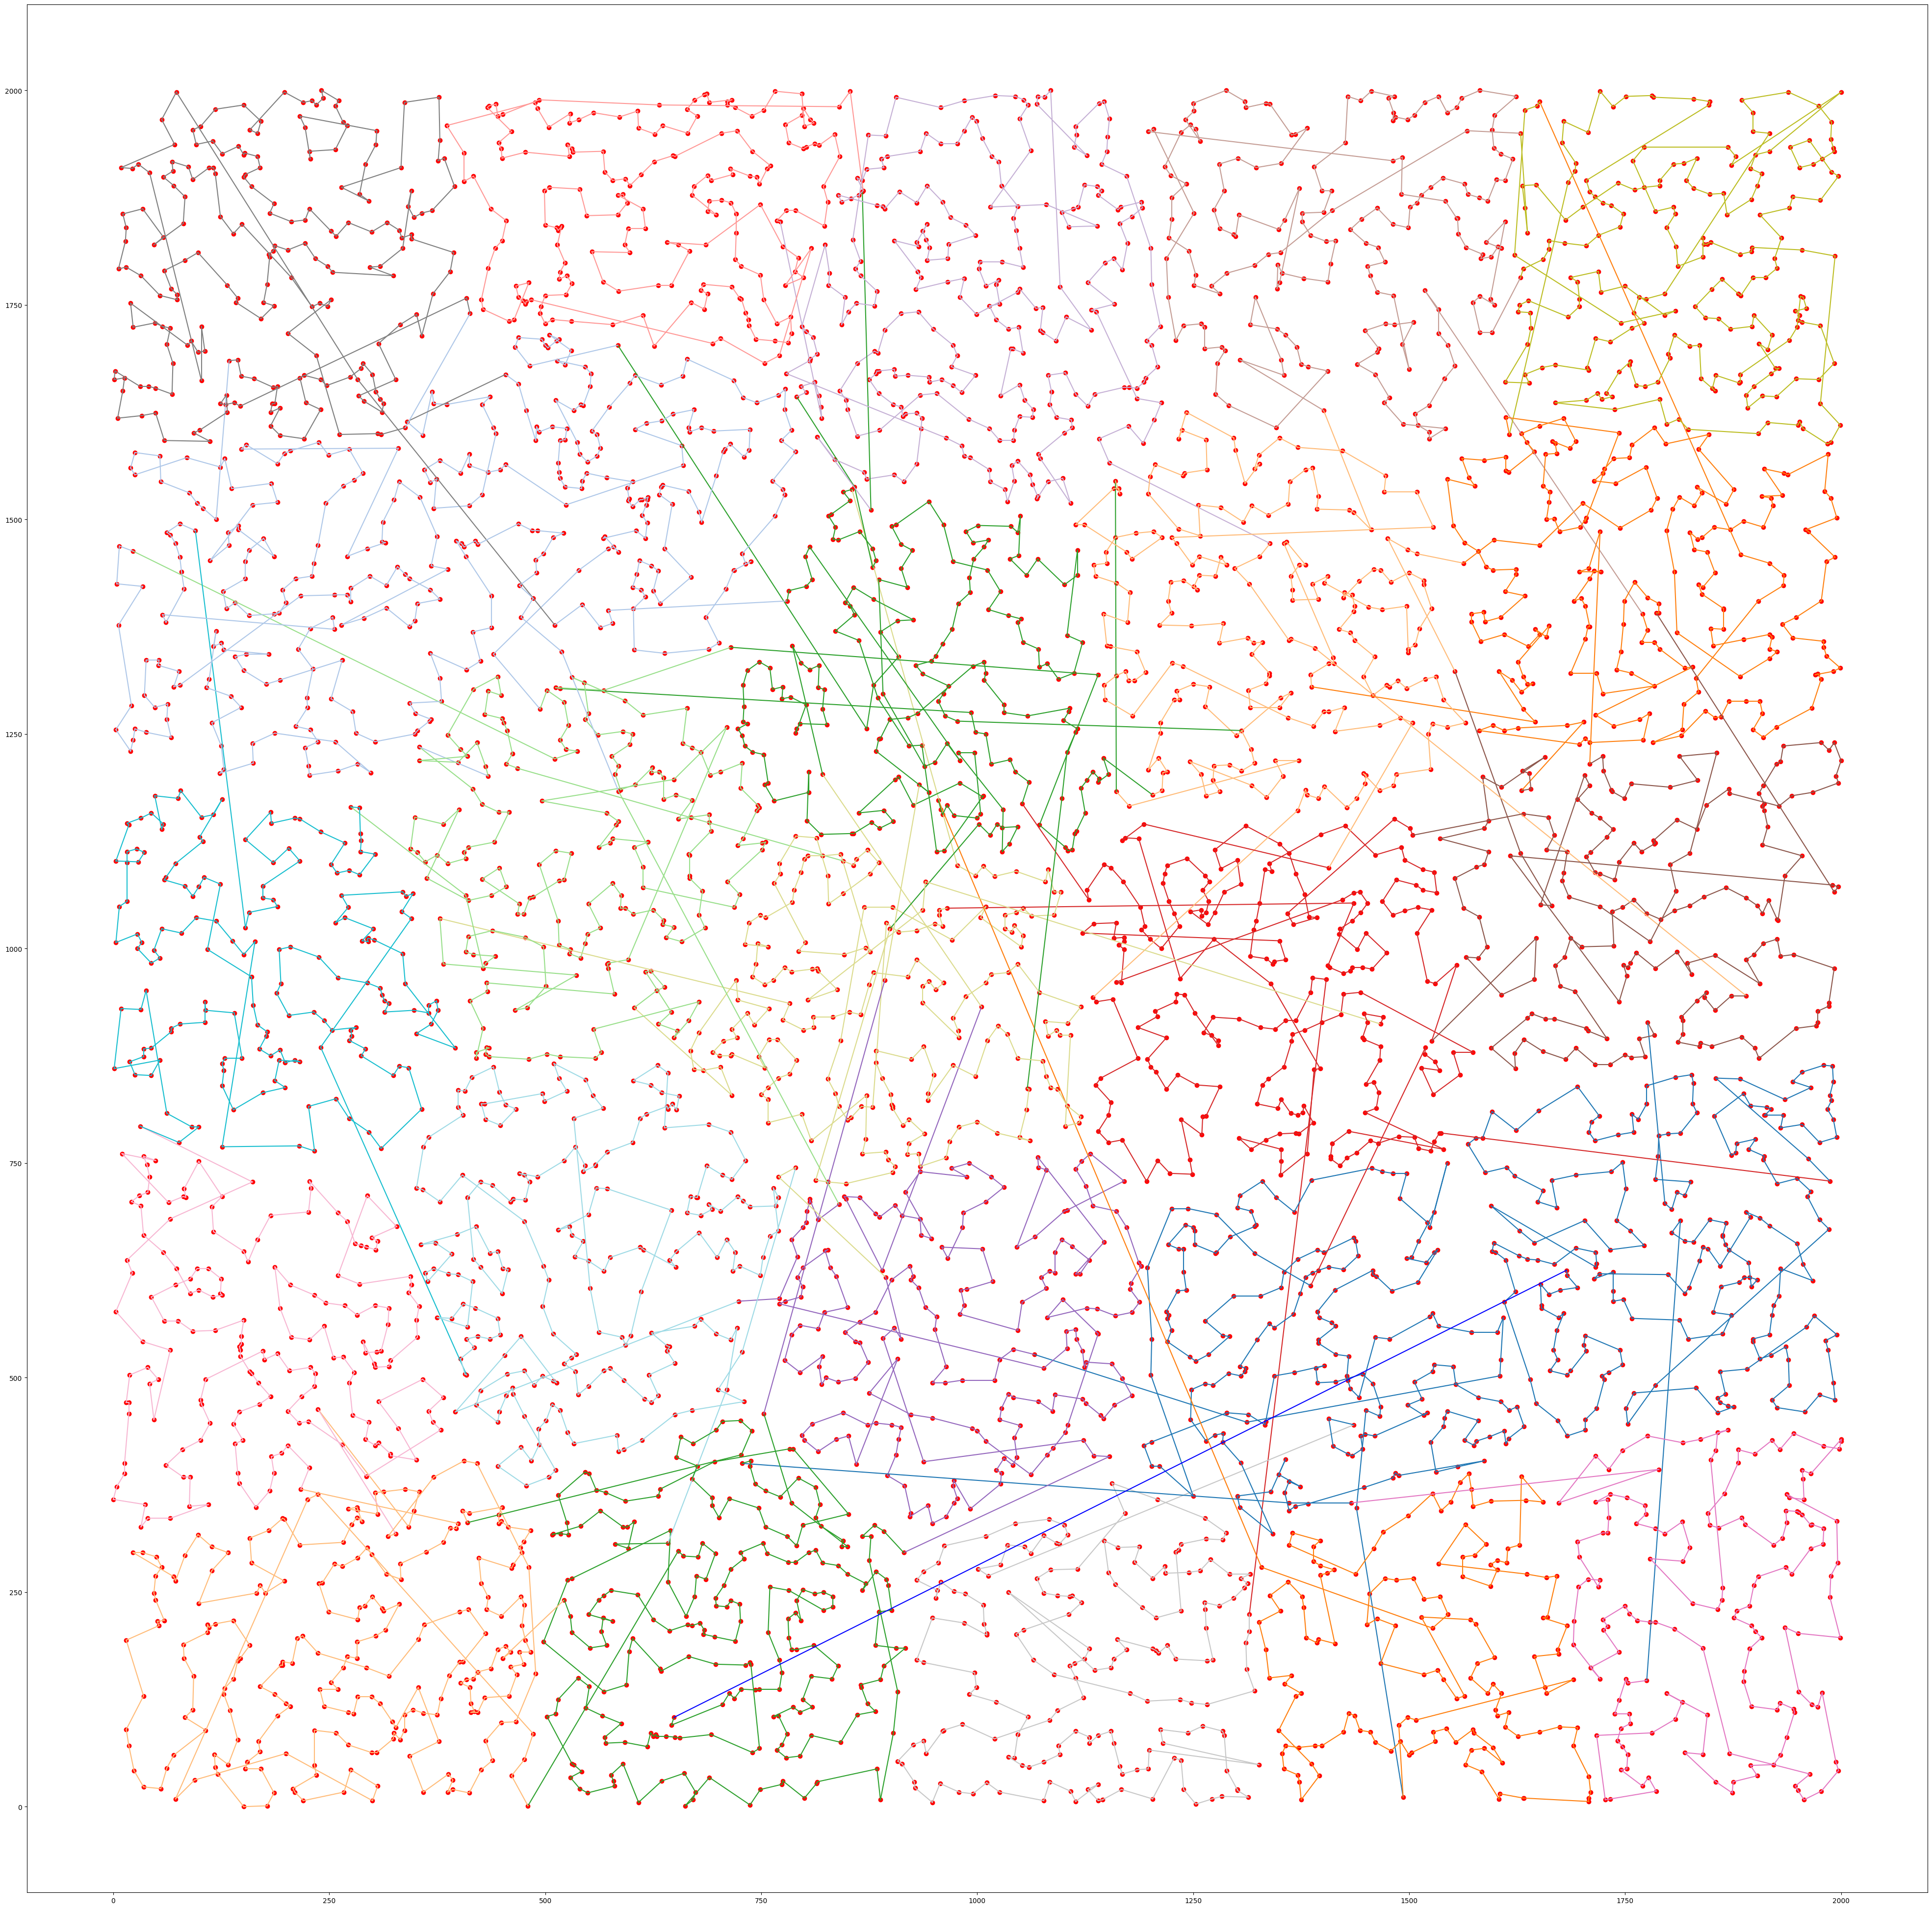

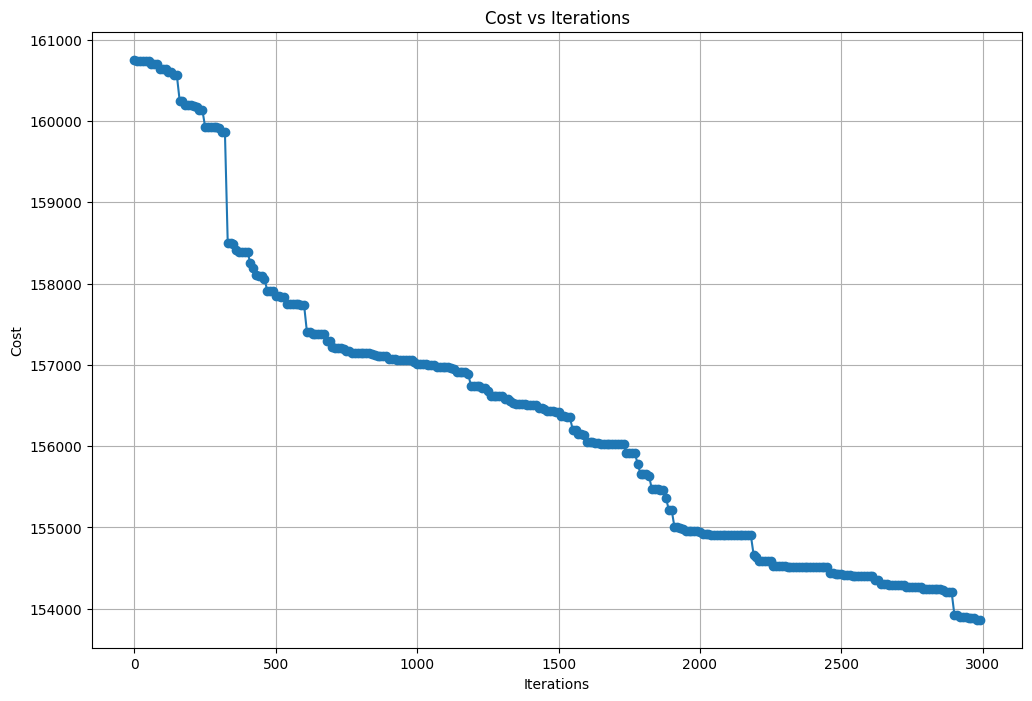

In [22]:
global K_CLUSTERS
K_CLUSTERS = 25
TABU_TENURE = 100
ITERATIONS = 3000
main()

# Performance tests

Calculating distance matrix:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating distance matrix: 100%|██████████| 100/100 [00:00<00:00, 8577.84it/s]


---------------------------------------------------------------------
Starting iteration 1 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=10, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 6798.01it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 1675.94it/s]


---------------------------------------------------------------------
Starting iteration 2 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=10, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 12365.28it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 2000/2000 [00:01<00:00, 1777.89it/s]


---------------------------------------------------------------------
Starting iteration 3 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=10, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 12604.21it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 2500/2500 [00:01<00:00, 1806.71it/s]


---------------------------------------------------------------------
Starting iteration 4 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=10, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 12448.59it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 3000/3000 [00:01<00:00, 1704.53it/s]


---------------------------------------------------------------------
Starting iteration 5 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=50, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 13185.49it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 1532.17it/s]


---------------------------------------------------------------------
Starting iteration 6 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=50, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 12848.62it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 2000/2000 [00:01<00:00, 1770.79it/s]


---------------------------------------------------------------------
Starting iteration 7 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=50, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 12411.75it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 2500/2500 [00:01<00:00, 1792.26it/s]


---------------------------------------------------------------------
Starting iteration 8 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=50, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 12451.92it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 3000/3000 [00:01<00:00, 1683.60it/s]


---------------------------------------------------------------------
Starting iteration 9 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=100, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 10967.22it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 1623.54it/s]


---------------------------------------------------------------------
Starting iteration 10 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=100, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 12106.52it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 2000/2000 [00:01<00:00, 1785.52it/s]


---------------------------------------------------------------------
Starting iteration 11 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=100, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 10404.60it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 2500/2500 [00:01<00:00, 1801.00it/s]


---------------------------------------------------------------------
Starting iteration 12 of 72
Parameters: K_CLUSTERS=5, TABU_TENURE=100, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 12371.48it/s]


Initial Solution Cost: 1261.7931657993518


Tabu search iterations: 100%|██████████| 3000/3000 [00:01<00:00, 1739.31it/s]


---------------------------------------------------------------------
Starting iteration 13 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=10, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9365.00it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 3352.32it/s]


---------------------------------------------------------------------
Starting iteration 14 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=10, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9288.68it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 3493.49it/s]


---------------------------------------------------------------------
Starting iteration 15 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=10, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9404.69it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 3544.34it/s]


---------------------------------------------------------------------
Starting iteration 16 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=10, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9183.33it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 3517.96it/s]


---------------------------------------------------------------------
Starting iteration 17 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=50, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9627.47it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 3340.80it/s]


---------------------------------------------------------------------
Starting iteration 18 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=50, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9571.23it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 3480.02it/s]


---------------------------------------------------------------------
Starting iteration 19 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=50, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9468.81it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 3555.16it/s]


---------------------------------------------------------------------
Starting iteration 20 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=50, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9520.18it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 3505.63it/s]


---------------------------------------------------------------------
Starting iteration 21 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=100, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9794.05it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 3430.88it/s]


---------------------------------------------------------------------
Starting iteration 22 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=100, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9550.09it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 3520.48it/s]


---------------------------------------------------------------------
Starting iteration 23 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=100, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9289.50it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 3482.18it/s]


---------------------------------------------------------------------
Starting iteration 24 of 72
Parameters: K_CLUSTERS=10, TABU_TENURE=100, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 9636.76it/s]


Initial Solution Cost: 1363.7969850168665


Tabu search iterations: 100%|██████████| 3000/3000 [00:01<00:00, 2897.61it/s]


---------------------------------------------------------------------
Starting iteration 25 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=10, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7170.12it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 5903.28it/s]


---------------------------------------------------------------------
Starting iteration 26 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=10, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 6984.22it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 5867.16it/s]


---------------------------------------------------------------------
Starting iteration 27 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=10, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7234.93it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 5715.23it/s]


---------------------------------------------------------------------
Starting iteration 28 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=10, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 6726.28it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 5695.24it/s]


---------------------------------------------------------------------
Starting iteration 29 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=50, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7200.89it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 5615.94it/s]


---------------------------------------------------------------------
Starting iteration 30 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=50, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7119.49it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 5301.86it/s]


---------------------------------------------------------------------
Starting iteration 31 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=50, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7323.35it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 5068.76it/s]


---------------------------------------------------------------------
Starting iteration 32 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=50, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7305.11it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 5541.55it/s]


---------------------------------------------------------------------
Starting iteration 33 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=100, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7109.71it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 5297.47it/s]


---------------------------------------------------------------------
Starting iteration 34 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=100, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7323.86it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 4974.37it/s]


---------------------------------------------------------------------
Starting iteration 35 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=100, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7153.73it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 5393.23it/s]


---------------------------------------------------------------------
Starting iteration 36 of 72
Parameters: K_CLUSTERS=15, TABU_TENURE=100, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 7292.79it/s]


Initial Solution Cost: 1424.942888471652


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 5692.45it/s]


---------------------------------------------------------------------
Starting iteration 37 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=10, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5792.36it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 6409.10it/s]


---------------------------------------------------------------------
Starting iteration 38 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=10, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5025.65it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 5629.20it/s]


---------------------------------------------------------------------
Starting iteration 39 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=10, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5487.92it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 6474.37it/s]


---------------------------------------------------------------------
Starting iteration 40 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=10, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5846.94it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 5820.47it/s]


---------------------------------------------------------------------
Starting iteration 41 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=50, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5739.49it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 6852.29it/s]


---------------------------------------------------------------------
Starting iteration 42 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=50, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4937.50it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 4995.98it/s]


---------------------------------------------------------------------
Starting iteration 43 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=50, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5703.51it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 6586.05it/s]


---------------------------------------------------------------------
Starting iteration 44 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=50, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5745.86it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 6446.46it/s]


---------------------------------------------------------------------
Starting iteration 45 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=100, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5726.09it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 6653.51it/s]


---------------------------------------------------------------------
Starting iteration 46 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=100, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5060.94it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 4899.89it/s]


---------------------------------------------------------------------
Starting iteration 47 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=100, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4908.20it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 5764.88it/s]


---------------------------------------------------------------------
Starting iteration 48 of 72
Parameters: K_CLUSTERS=20, TABU_TENURE=100, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 5328.74it/s]


Initial Solution Cost: 1965.6843117576577


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 6137.53it/s]


---------------------------------------------------------------------
Starting iteration 49 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=10, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4902.18it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 8173.06it/s]


---------------------------------------------------------------------
Starting iteration 50 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=10, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4277.50it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 6502.18it/s]


---------------------------------------------------------------------
Starting iteration 51 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=10, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4265.32it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 7315.63it/s]


---------------------------------------------------------------------
Starting iteration 52 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=10, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4775.32it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 7870.73it/s]


---------------------------------------------------------------------
Starting iteration 53 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=50, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4970.50it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 7998.13it/s]


---------------------------------------------------------------------
Starting iteration 54 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=50, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 3773.89it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 5545.30it/s]


---------------------------------------------------------------------
Starting iteration 55 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=50, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 2995.55it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 6777.91it/s]


---------------------------------------------------------------------
Starting iteration 56 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=50, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4331.26it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 7476.15it/s]


---------------------------------------------------------------------
Starting iteration 57 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=100, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4931.23it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 8213.43it/s]


---------------------------------------------------------------------
Starting iteration 58 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=100, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4470.49it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 5579.38it/s]


---------------------------------------------------------------------
Starting iteration 59 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=100, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4543.22it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 7669.35it/s]


---------------------------------------------------------------------
Starting iteration 60 of 72
Parameters: K_CLUSTERS=25, TABU_TENURE=100, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4194.64it/s]


Initial Solution Cost: 2144.579707961196


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 7225.62it/s]


---------------------------------------------------------------------
Starting iteration 61 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=10, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4333.67it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 11569.58it/s]


---------------------------------------------------------------------
Starting iteration 62 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=10, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 3617.03it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 7510.81it/s]


---------------------------------------------------------------------
Starting iteration 63 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=10, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 1442.92it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 7475.07it/s]


---------------------------------------------------------------------
Starting iteration 64 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=10, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4320.77it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 10427.01it/s]


---------------------------------------------------------------------
Starting iteration 65 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=50, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 3764.48it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 9392.03it/s]


---------------------------------------------------------------------
Starting iteration 66 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=50, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 2570.70it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 7078.67it/s]


---------------------------------------------------------------------
Starting iteration 67 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=50, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 3742.01it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 9516.52it/s]


---------------------------------------------------------------------
Starting iteration 68 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=50, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 3769.58it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 8721.97it/s]


---------------------------------------------------------------------
Starting iteration 69 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=100, ITERATIONS=1500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4400.28it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 1500/1500 [00:00<00:00, 10350.90it/s]


---------------------------------------------------------------------
Starting iteration 70 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=100, ITERATIONS=2000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 3543.95it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 2000/2000 [00:00<00:00, 5842.47it/s]


---------------------------------------------------------------------
Starting iteration 71 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=100, ITERATIONS=2500
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 3140.60it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 2500/2500 [00:00<00:00, 8387.18it/s]


---------------------------------------------------------------------
Starting iteration 72 of 72
Parameters: K_CLUSTERS=30, TABU_TENURE=100, ITERATIONS=3000
---------------------------------------------------------------------


Clustering cities: 100%|██████████| 100/100 [00:00<00:00, 4148.71it/s]


Initial Solution Cost: 2384.063351615757


Tabu search iterations: 100%|██████████| 3000/3000 [00:00<00:00, 9726.05it/s] 


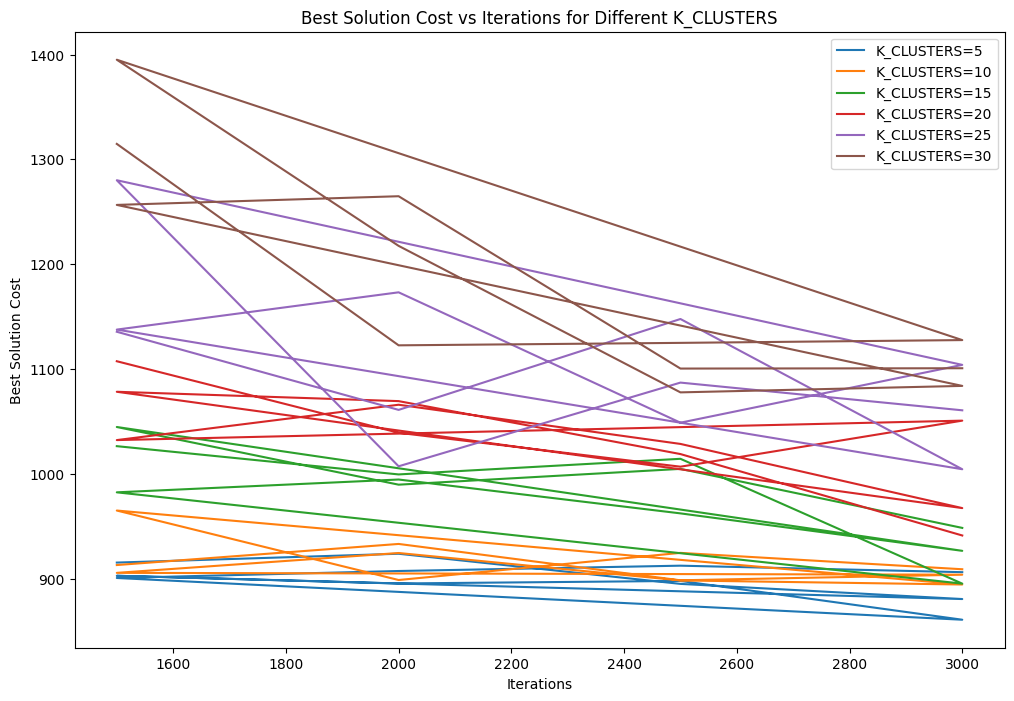

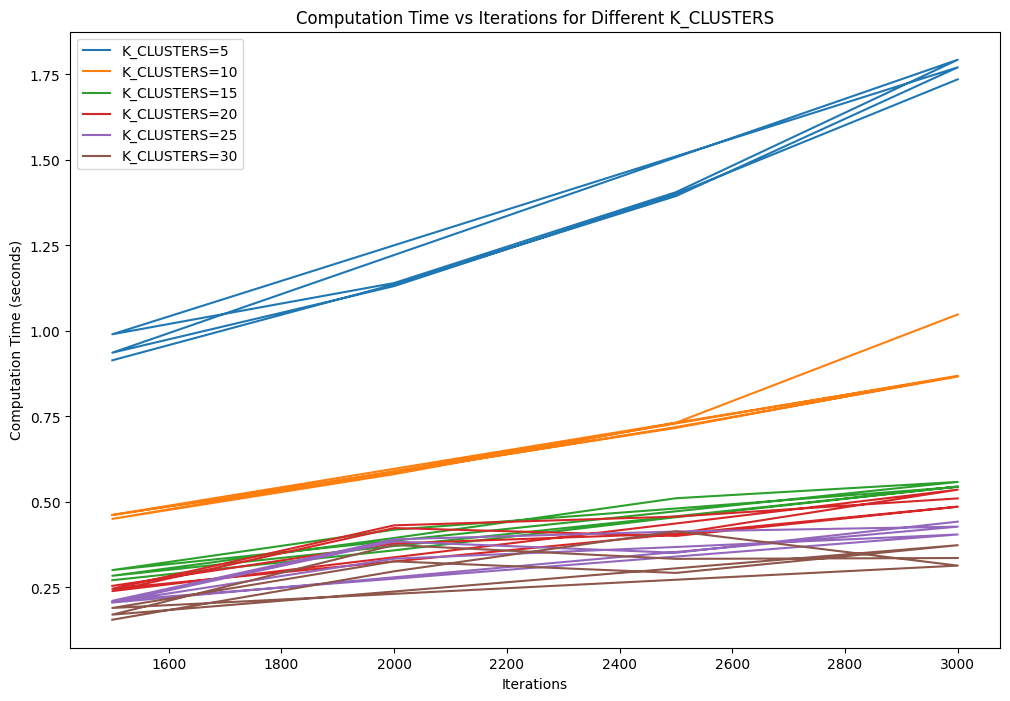

In [33]:
k_clusters_list = [5, 10, 15, 20, 25, 30]
tabu_tenure_list = [10, 50, 100]
iterations_list = [1500, 2000, 2500, 3000]
analyze_performance(k_clusters_list,tabu_tenure_list,iterations_list)